In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits, fetch_openml
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import (silhouette_score, homogeneity_score, completeness_score, v_measure_score, 
                             homogeneity_completeness_v_measure)
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.manifold import TSNE

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [2]:
X, y = load_digits(return_X_y=True)

In [3]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [4]:
imgs = X[:10].reshape(-1, 8, 8)
imgs.shape

(10, 8, 8)

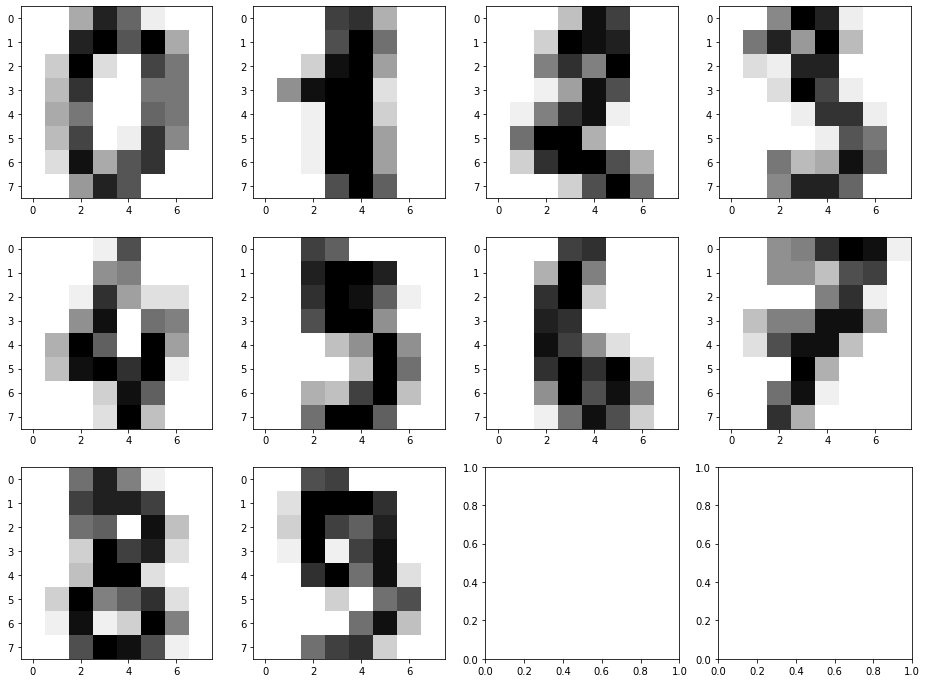

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

i = 0
for row in axes:
    for subplot in row:
        if i < 10:
            subplot.imshow(16 - imgs[i], cmap='gray')
            i += 1

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [6]:
# Let's scale the data as we are dealing with distance-based algorithms.

X_norm = MinMaxScaler().fit_transform(X)

In [7]:
# Hierarchical Agglomerative

agg = AgglomerativeClustering(n_clusters=10)

agg_pred = agg.fit_predict(X_norm)
print(agg_pred.shape)
print(*agg_pred[:20])

(1797,)
7 9 4 0 2 0 6 3 4 0 7 8 5 0 2 1 6 3 4 0


In [8]:
# K-Means

kmeans = KMeans(n_clusters=10, n_init=100, random_state=18)

kmeans_pred = kmeans.fit_predict(X_norm)
print(kmeans_pred.shape)
print(*kmeans_pred[:20])

(1797,)
8 2 2 9 4 0 5 1 2 0 8 6 3 9 4 7 5 1 2 0


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

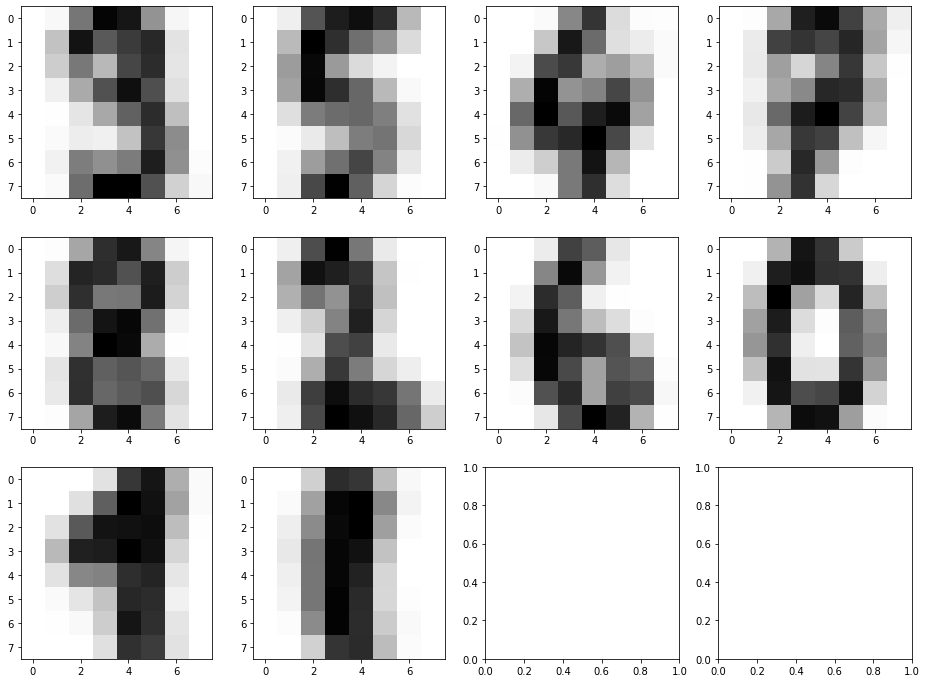

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in set(agg_pred):
    cluster_cent = X[agg_pred == i, :].mean(axis=0).reshape(8, 8)
    axes.flat[i].imshow(16 - cluster_cent, cmap='gray')

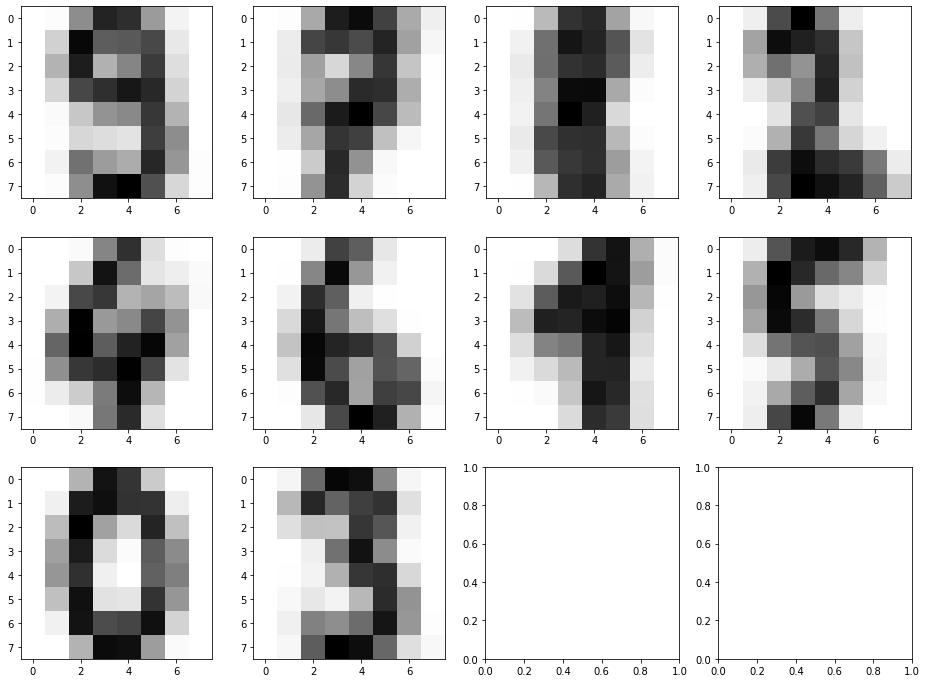

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in set(kmeans_pred):
    cluster_cent = X[kmeans_pred == i, :].mean(axis=0).reshape(8, 8)
    axes.flat[i].imshow(16 - cluster_cent, cmap='gray')

It's not that obvious what algo produced better results.  
The *'7'* is not very nice in both outcomes, K-Means *'8'* is simply awful and so is Hierarchical's *'9'* (or maybe *'3'*, I'm not sure).  
But overall the numbers of **K-means** seem somewhat clearer to me. 

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [11]:
k_num = list(range(2, 21))
k_means_silhouette = []
agg_silhouette = []

for k in k_num:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=18)
    agg = AgglomerativeClustering(n_clusters=k)
    
    kmeans_pred = kmeans.fit_predict(X_norm)
    agg_pred = agg.fit_predict(X_norm)    
    
    k_means_silhouette.append(silhouette_score(X_norm, kmeans_pred))
    agg_silhouette.append(silhouette_score(X_norm, agg_pred))
    
print(f"K-Means Silhouette at K==10 is {k_means_silhouette[8]}")
print(f"Hierarchical Silhouette at K==10 is {agg_silhouette[8]}")

K-Means Silhouette at K==10 is 0.18113622477258207
Hierarchical Silhouette at K==10 is 0.1763351275744565


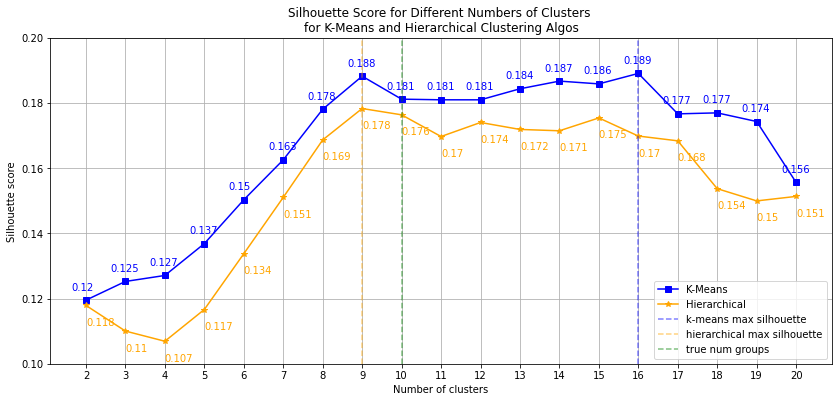

In [12]:
plt.figure(figsize=(14, 6))

plt.plot(k_means_silhouette, label='K-Means', color='b', marker='s')
for i, j in zip(range(len(k_num)), k_means_silhouette):
    plt.annotate(str(round(j, 3)), xy=(i, j), xytext=(-15, 10), textcoords='offset pixels', color='b')
    
plt.plot(agg_silhouette, label='Hierarchical', color='orange', marker='*')
for i, j in zip(range(len(k_num)), agg_silhouette):
    plt.annotate(str(round(j, 3)), xy=(i, j), xytext=(0, -20), textcoords='offset pixels', color='orange')
    
plt.axvline(np.argmax(k_means_silhouette), label='k-means max silhouette', color='b', linestyle='--', alpha=0.5)
plt.axvline(np.argmax(agg_silhouette), label='hierarchical max silhouette', color='orange', linestyle='--', alpha=0.5)
plt.axvline(8, label='true num groups', color='g', linestyle='--', alpha=0.5)

plt.title('Silhouette Score for Different Numbers of Clusters \nfor K-Means and Hierarchical Clustering Algos')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.ylim(0.1, 0.2)
plt.grid()
plt.legend(loc='lower right')
plt.xticks(ticks=range(len(k_num)), labels=k_num);

According to **silhouette** metric, we should pick **9** for *Hierarchical* clustering algo and **16**(O_o) for *K-Means*.  
Well, silhouette metric of K-Means for 16 clusters is only slightly higher than for 9 (as Hierarchical suggests).  
Though while 9 is close to true number of groups (10 obviously), it is still wrong.  
K-Means Silhouette at K==10 is 0.181  
Hierarchical Silhouette at K==10 is 0.176

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [13]:
k_num = list(range(2, 21))
k_means_v_measure = []
agg_v_measure = []

for k in k_num:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=18)
    agg = AgglomerativeClustering(n_clusters=k)
    
    kmeans_pred = kmeans.fit_predict(X_norm)
    agg_pred = agg.fit_predict(X_norm)    
    
    k_means_v_measure.append(v_measure_score(y, kmeans_pred))
    agg_v_measure.append(v_measure_score(y, agg_pred))
    
print(f"K-Means V-measure at K==10 is {k_means_v_measure[8]}")
print(f"Hierarchical V-measure at K==10 is {agg_v_measure[8]}")

K-Means V-measure at K==10 is 0.7441621301144463
Hierarchical V-measure at K==10 is 0.8630220579864901


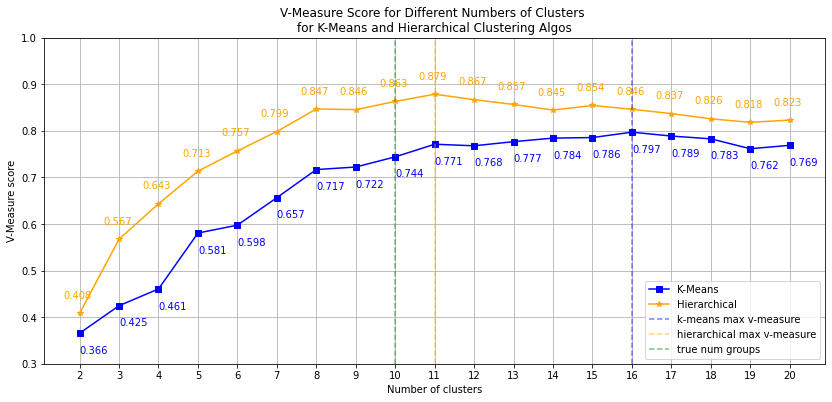

In [14]:
plt.figure(figsize=(14, 6))

plt.plot(k_means_v_measure, label='K-Means', color='b', marker='s')
for i, j in zip(range(len(k_num)), k_means_v_measure):
    plt.annotate(str(round(j, 3)), xy=(i, j), xytext=(0, -20), textcoords='offset pixels', color='b')
    
plt.plot(agg_v_measure, label='Hierarchical', color='orange', marker='*')
for i, j in zip(range(len(k_num)), agg_v_measure):
    plt.annotate(str(round(j, 3)), xy=(i, j), xytext=(-16, 15), textcoords='offset pixels', color='orange')
    
plt.axvline(np.argmax(k_means_v_measure), label='k-means max v-measure', color='b', linestyle='--', alpha=0.5)
plt.axvline(np.argmax(agg_v_measure), label='hierarchical max v-measure', color='orange', linestyle='--', alpha=0.5)
plt.axvline(8, label='true num groups', color='g', linestyle='--', alpha=0.5)

plt.title('V-Measure Score for Different Numbers of Clusters \nfor K-Means and Hierarchical Clustering Algos')
plt.xlabel('Number of clusters')
plt.ylabel('V-Measure score')
plt.ylim(0.3, 1)
plt.grid()
plt.legend(loc='lower right')
plt.xticks(ticks=range(len(k_num)), labels=k_num);

Well, *K-Means* stands persistent. According to **v-measure** metric the best result we achieved from *k-means* had been again achived with **16** clusters.  
As for *Hierarchical* clustering algo, we have maximum **v-measure** at k == **12**, but it is just in 4th decimal digit bigger than the correct answer which is 10.  
K-Means V-measure at K==10 is 0.744  
Hierarchical V-measure at K==10 is 0.863

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [15]:
new_dims = [20, 10, 5, 2]
reduce_kmeans_silhouette = []
reduce_kmeans_vmeasure = []
reduce_agg_silhouette = []
reduce_agg_vmeasure = []

kmeans = KMeans(n_clusters=10, n_init=100, random_state=18)
agg = AgglomerativeClustering(n_clusters=10)

for d in new_dims:
    X_reduce = TruncatedSVD(n_components=d).fit_transform(X_norm)
      
    kmeans_pred = kmeans.fit_predict(X_reduce)
    agg_pred = agg.fit_predict(X_reduce)
    
    reduce_kmeans_silhouette.append(silhouette_score(X_reduce, kmeans_pred))
    reduce_kmeans_vmeasure.append(v_measure_score(y, kmeans_pred))
    
    reduce_agg_silhouette.append(silhouette_score(X_reduce, agg_pred))
    reduce_agg_vmeasure.append(v_measure_score(y, agg_pred))

print(f"Maximum Silhouette for K-Means is {max(reduce_kmeans_silhouette)} at "
f"{new_dims[np.argmax(reduce_kmeans_silhouette)]} dimensions.")
print(f"Maximum Silhouette for Hierarchical is {max(reduce_agg_silhouette)} at "
f"{new_dims[np.argmax(reduce_agg_silhouette)]} dimensions.")

print(f"Maximum V-measure for K-Means is {max(reduce_kmeans_vmeasure)} at "
f"{new_dims[np.argmax(reduce_kmeans_vmeasure)]} dimensions.")
print(f"Maximum V-measure for Hierarchical is {max(reduce_agg_vmeasure)} at "
f"{new_dims[np.argmax(reduce_agg_vmeasure)]} dimensions.")

Maximum Silhouette for K-Means is 0.3558099468995888 at 2 dimensions.
Maximum Silhouette for Hierarchical is 0.2932975558799318 at 2 dimensions.
Maximum V-measure for K-Means is 0.7418384316293407 at 20 dimensions.
Maximum V-measure for Hierarchical is 0.8394649940421345 at 20 dimensions.


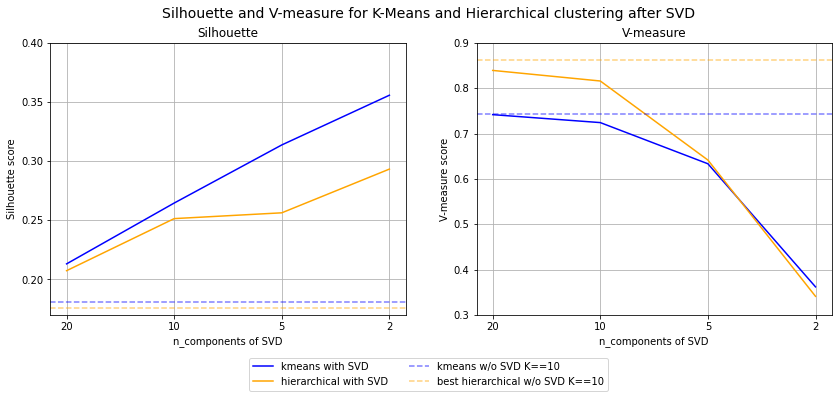

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Silhouette and V-measure for K-Means and Hierarchical clustering after SVD', size=14)

axes[0].plot(reduce_kmeans_silhouette, label='kmeans with SVD', color='b')
axes[0].plot(reduce_agg_silhouette, label='hierarchical with SVD', color='orange')
axes[0].axhline(0.181, label='kmeans w/o SVD K==10', color='b', linestyle='--', alpha=0.5)
axes[0].axhline(0.176, label='best hierarchical w/o SVD K==10', color='orange', linestyle='--', alpha=0.5)
axes[0].set_title('Silhouette')
axes[0].set(xlabel='n_components of SVD', ylabel='Silhouette score', ylim=(0.17, 0.4))

axes[1].plot(reduce_kmeans_vmeasure, color='b')
axes[1].plot(reduce_agg_vmeasure, color='orange')
axes[1].axhline(0.744, color='b', linestyle='--', alpha=0.5)
axes[1].axhline(0.863, color='orange', linestyle='--', alpha=0.5)
axes[1].set_title('V-measure')
axes[1].set(xlabel='n_components of SVD', ylabel='V-measure score', ylim=(0.3, 0.9))

for ax in axes:
    ax.set_xticks(range(len(new_dims)))
    ax.set_xticklabels(new_dims)
    ax.grid()

fig.legend(bbox_to_anchor=(0.5,-0.1), loc='lower center',ncol=2);

Well, it seems that SVD worked **extremely well** for the *silhouette metric*: even reduction to the dimension of 20 improved the score for both algos and the more dimension reduction - the more silhouette score improvement, especially for k-means. K-means silhouette score for K == 10 has rizen *from 0.18 w/o SVD up to 0.35 with SVD reduction with n_components == 2*. But I'm not sure we can sensefully compare the silhouette in different dimensions, because distance levels off with dimensionality increase, thus lowering the silhouette score.   
As for V-measure, we see the opposite picture: for both algos SVD drops the score dramatically and the more dimensions are dropped - the more v-measure score is being lost.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [18]:
tsne = TSNE(n_components=2)
X_reduce = tsne.fit_transform(X_norm)

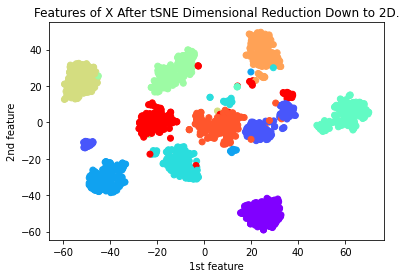

In [19]:
plt.scatter(X_reduce[:, 0], X_reduce[:, 1], c=y, cmap='rainbow')
plt.title('Features of X After tSNE Dimensional Reduction Down to 2D.')
plt.xlabel('1st feature')
plt.ylabel('2nd feature');

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [20]:
X_reduce = tsne.fit_transform(X_norm)

kmeans = KMeans(n_clusters=10, n_init=100, random_state=18)
agg = AgglomerativeClustering(n_clusters=10)

kmeans_pred = kmeans.fit_predict(X_reduce)
agg_pred = agg.fit_predict(X_reduce)

tsne_kmeans_silhouette = silhouette_score(X_reduce, kmeans_pred)
tsne_kmeans_vmeasure = v_measure_score(y, kmeans_pred)

tsne_agg_silhouette = silhouette_score(X_reduce, agg_pred)
tsne_agg_vmeasure = v_measure_score(y, agg_pred)

In [21]:
print(f"Silhouette for K-Means after tSNE:\t{tsne_kmeans_silhouette}")
print(f"Silhouette for Hierarchical after tSNE:\t{tsne_agg_silhouette}")
print(f"\nV-measure for K-Means after tSNE:\t{tsne_kmeans_vmeasure}")
print(f"V-measure for Hierarchical after tSNE:\t{tsne_agg_vmeasure}")

Silhouette for K-Means after tSNE:	0.6416090130805969
Silhouette for Hierarchical after tSNE:	0.6402596235275269

V-measure for K-Means after tSNE:	0.9059582452402487
V-measure for Hierarchical after tSNE:	0.9090080008547311


We've got much better results after applying tSNE in comparison with initial data: silhouette has become 3 times higher while v-measure increased by about 30%. 

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [22]:
# Let's make a DF summary of our results

summary = pd.DataFrame({'Algo': ['KMeans'] * 3 + ['Hierarch'] * 3, 
              'Preprocess': ['Best Raw Data', 'Best SVD', 'tSNE'] * 2,
              'Silhouette':[0.181, 0.356, 0.647, 0.176, 0.293, 0.647], 
              'V-measure':[0.744, 0.742, 0.911, 0.863, 0.839, 0.910]})

summary

,Algo,Preprocess,Silhouette,V-measure
0,KMeans,Best Raw Data,0.181,0.744
1,KMeans,Best SVD,0.356,0.742
2,KMeans,tSNE,0.647,0.911
3,Hierarch,Best Raw Data,0.176,0.863
4,Hierarch,Best SVD,0.293,0.839
5,Hierarch,tSNE,0.647,0.910


In [23]:
# We'll pick K-Means after t-SNE

kmeans = KMeans(n_clusters=10, n_init=100, random_state=18)
X_reduce = tsne.fit_transform(X_norm)
kmeans_pred = kmeans.fit_predict(X_reduce)

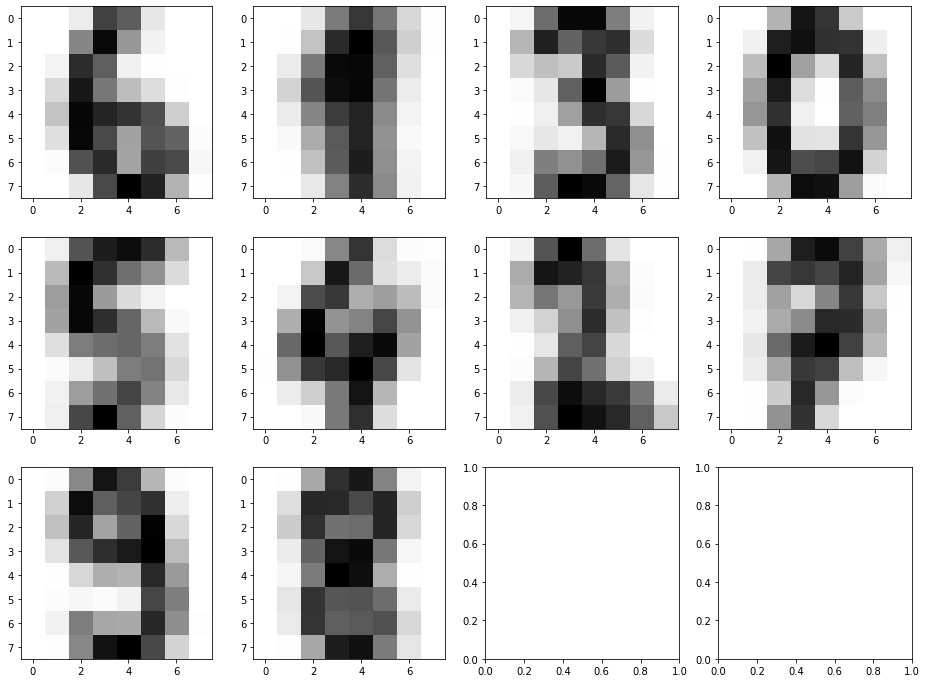

In [24]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in set(kmeans_pred):
    cluster_cent = X[kmeans_pred == i, :].mean(axis=0).reshape(8, 8)
    axes.flat[i].imshow(16 - cluster_cent, cmap='gray')

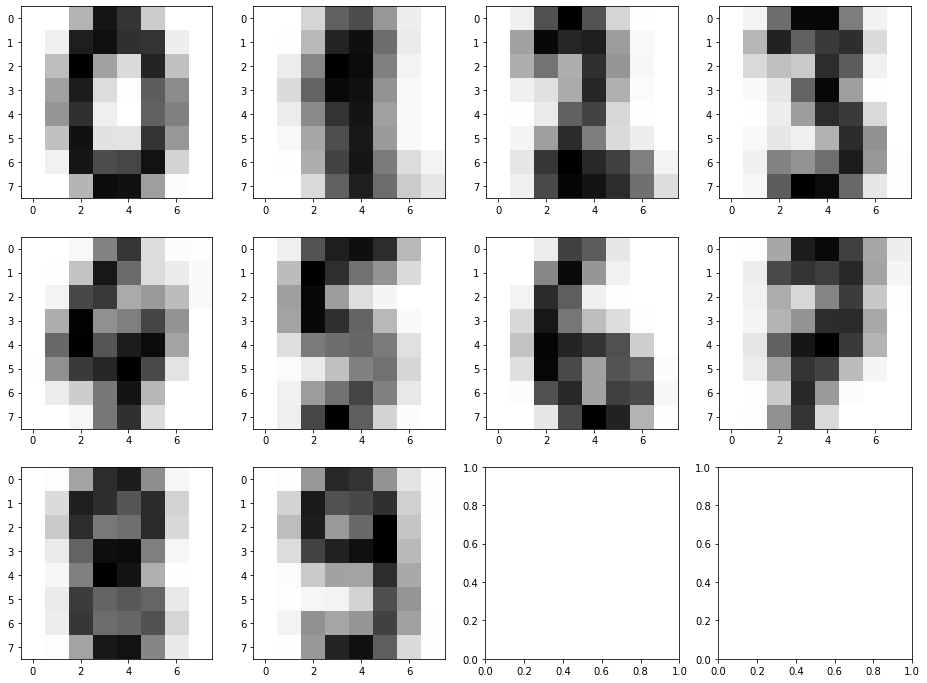

In [25]:
# And true clusters for comparison

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in set(y):
    cluster_cent = X[np.array(y) == i, :].mean(axis=0).reshape(8, 8)
    axes.flat[i].imshow(16 - cluster_cent, cmap='gray')

Well, we must admit that tSNE helped a lot. We had a problem with k-means recognizing and clustering '8' when using initial data. And now after tSNE's work we clearly see all the 10 digits. More of that, clustering result after tSNE has produced digits almost the same as true mean labels.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

As for algorithm performance difference, it is not obvious at all, which of them produces better results. It varies greatly from the metric used: most of time v-measure shows Hierarchical's advantage while silhouette ranks K-Means slightly outperforming.  
It doesn't greatly depend on algorithms' hyperparameters' tuning - both of them behave similarly when changing n_clusters. Still some differences and fluctuations from parallel behaviour take place. Wide-range altering of k-means number of initial clustering positioning parameter also produces some decrease in metric, but it is not that much.  
It is not that clear with the Dimensionality reduction. If speaking about PCA (SVD), we saw performance dropped dramatically according to v-measure metric and increased greatly according to the silhouette metric when truncating features down to 2D space. Very puzzling, I'd say...   
The more surprising was the fact that DR using tSNE technique helped a lot! It boosted the performance greatly and let our algos produce clusters wich were practically the same as true ones.  
Also, numbers 3, 8 and 9 predictably turned to be the hardest to separate from each other (because they have much in common as for spelling).

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

***Disclaimer: I failed installing UMAP lib locally, so I've done this task in two ways:***
- using tSNE in this notebook;
- using UMAP in CoLab (got somewhat better results there) which is available via [this link](https://colab.research.google.com/drive/1ez8i-1dkylTbmqr3EaRyCrafOg5gufIG?usp=sharing).

In [26]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [27]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [28]:
# Normilize data and perform Dim-reduction
# Note: long-time execution cell

X_norm = MinMaxScaler().fit_transform(X)

X_reduce = tsne.fit_transform(X_norm)

In [29]:
X_reduce.shape

(70000, 2)

In [30]:
# Clustering and evaluating
# Note: long-time execution cell

kmeans = KMeans(n_clusters=10, n_init=10, random_state=18)

kmeans_pred = kmeans.fit_predict(X_reduce)

tsne_kmeans_silhouette = silhouette_score(X_reduce, kmeans_pred)
tsne_kmeans_vmeasure = v_measure_score(y, kmeans_pred)

print(f"Silhouette: {tsne_kmeans_silhouette}")
print(f"V-measure: {tsne_kmeans_vmeasure}")

Silhouette: 0.3949599266052246
V-measure: 0.7386696275758436


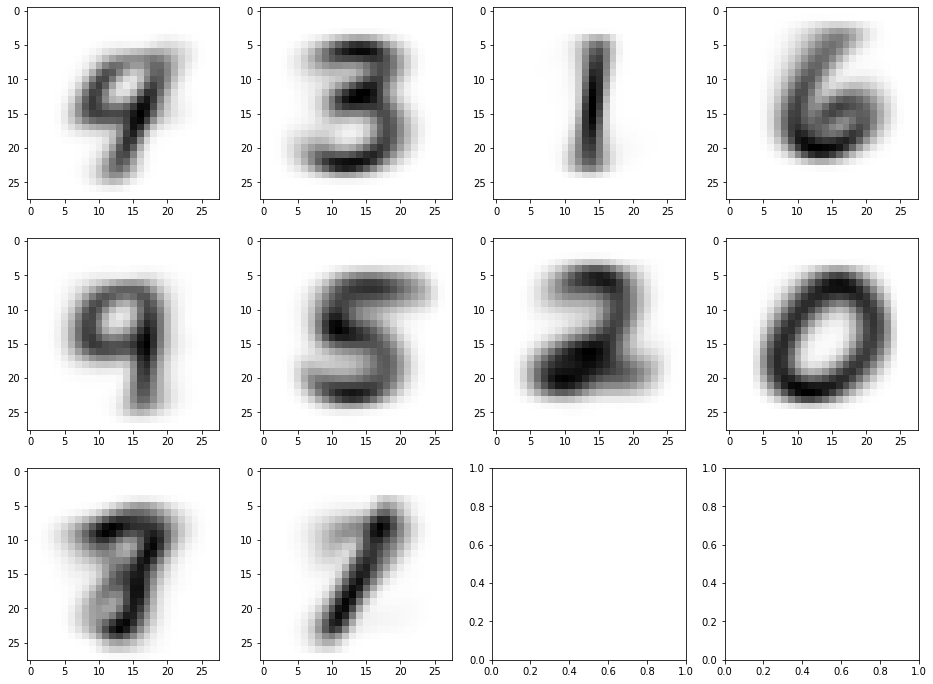

In [31]:
# Visualizing result

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in set(kmeans_pred):
    cluster_cent = np.array(X.iloc[kmeans_pred == i, :].mean(axis=0)).reshape(28, 28)
    axes.flat[i].imshow(255 - cluster_cent, cmap='gray')